# **Data Analysis for the Cleveland Health Data Set**

Please follow the in-line comments as well as the markdown text to understand what is going on in this notebook.

## *First, we load in necessary libraries and do a data sanity check*

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

I wanted to make sure that I removed some of the features that I know nothing about. Even though there could be some correlation with them, I don't want to risk making a mistake or false claim. It can be revisited after further research into the medical terminology.

In [3]:
data = pd.read_csv("../hcde-410-final/heart_cleveland_upload.csv")
# Removes some of the medical features that I don't know enough about to draw conclusions
data = data.drop(['thal', 'slope','oldpeak'], axis=1) 
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,ca,condition
0,69,1,0,160,234,1,2,131,0,1,0
1,69,0,0,140,239,0,0,151,0,2,0
2,66,0,0,150,226,0,0,114,0,0,0
3,65,1,0,138,282,1,2,174,0,1,1
4,64,1,0,110,211,0,2,144,1,0,0


In [43]:
data.shape

(297, 11)

In [4]:
# Removing any missing data
print("Before removing missing data:",data.shape)
data = data.dropna()
print("After removing missing data:",data.shape)

Before removing missing data: (297, 11)
After removing missing data: (297, 11)


In [5]:
# Gives us a sense of what the data looks like
warnings.filterwarnings('ignore')
mins = data.min()
maxs = data.max()
print("Data minimums:")
print(mins)
print()
print("Data maximums:")
print()
print(maxs)

Data minimums:
age           29
sex            0
cp             0
trestbps      94
chol         126
fbs            0
restecg        0
thalach       71
exang          0
ca             0
condition      0
dtype: int64

Data maximums:

age           77
sex            1
cp             3
trestbps     200
chol         564
fbs            1
restecg        2
thalach      202
exang          1
ca             3
condition      1
dtype: int64


Let's see how the data looks statistically:

In [6]:
# Gives us the statistical values of each column in the dataset
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,ca,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,0.676768,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,0.938965,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,3.000000,1.000000


## *We will now begin the data exploration*

These charts below will show the distribution of each feature in our dataset

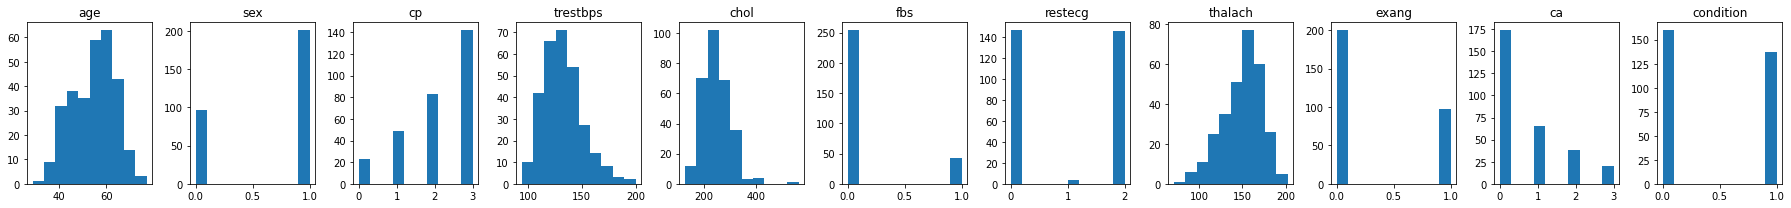

In [7]:
# This chart shows the distribution of all the variables in the dataset
fig, axes = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(25, 3))
for i, col in enumerate(data.columns):
    axes[i].hist(data[col], bins=10) 
    axes[i].set_title(col)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3) 
plt.show()

The bar chart below breaks down heart disease rates by age and sex. It appears that older females are the most susceptible in this case. *Keep in mind for sex 1 means male and 0 means female, and for condition, 1 means heart disease and 0 means no heart disease*

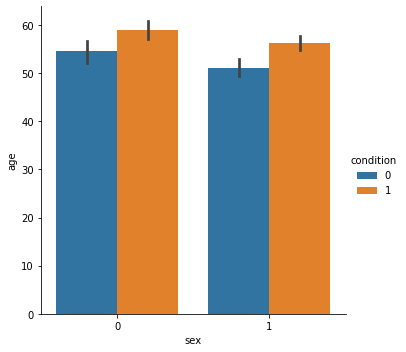

In [8]:
# Condition by sex
sns.catplot(kind = 'bar', data = data, y = 'age', x = 'sex', hue = 'condition')

The chart below, although a little crammed, shows the distribution of heart disease by age (youngest being at the left and oldest being at the right). You should be able to make out a higher rate of heart disease for those who are older. 

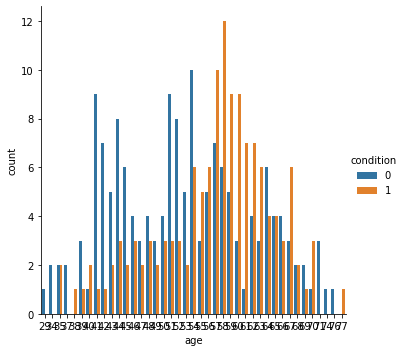

In [9]:
# Condition by age
sns.catplot(kind = 'count', data = data, x = 'age', hue = 'condition', order = data['age'].sort_values().unique())
plt.show()

The heatmap below shows the correlation between each variable in the dataset. If we look at the condition (column or row, either works) we can see which features have a linear relationship with heart disease rates. Something to note is that correlation doesn't always equal causation, so these types of charts should most likely be taken with a grain of salt, especially in the medical realm.

<AxesSubplot:>

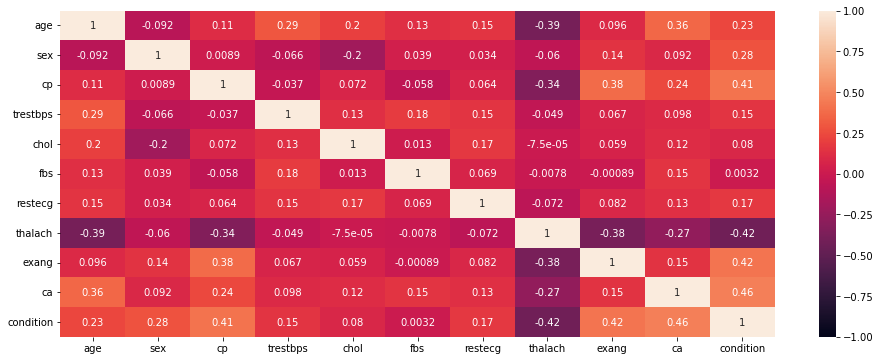

In [10]:
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)


The code below gives a simple reading on the mean and standard deviation of heart disease chances in this dataset.  

In [11]:
disMean = np.mean(data['condition'])
disStd = np.std(data['condition'])
print("Avg. disease chance: ", disMean)
print("Standard deviation of disease chance: ", disStd)

Avg. disease chance:  0.4612794612794613
Standard deviation of disease chance:  0.4984984652746594


### Data analysis on: Cholesterol


The code below gives us the average rate of heart disease with above and below average cholesterol levels.

In [12]:
dChol1 = data[data["chol"] > np.mean(data['chol'])]
gCholMean = np.mean(dChol1['condition'])
dChol2 = data[data["chol"] < np.mean(data['chol'])]
lCholMean = np.mean(dChol2['condition'])
print("Mean diease rate with above avg cholesterol", gCholMean, "Compared to lower than avg cholesterol: ", lCholMean)

Mean diease rate with above avg cholesterol 0.5407407407407407 Compared to lower than avg cholesterol:  0.3950617283950617


The code/graph below shows the relationship between cholesterol and heart disease via regression. It seems to show that as your cholesterol goes up, the more likely you are to have heart disease, however, the points on the graph are very spread out, and there seems to be a large margin of error. 

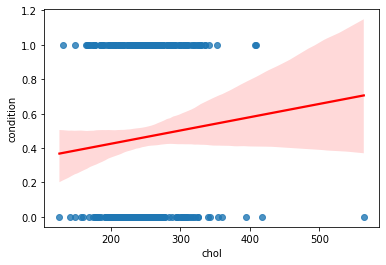

In [13]:
_ = sns.regplot(x = "chol", y = "condition",
                line_kws = {"color":"red"}, data = data)

The box and whiskers plot below shows the relationship between cholesterol and heart disease. It seems like the heart disease positive column (1) shows a little bit higher median cholesterol levels.

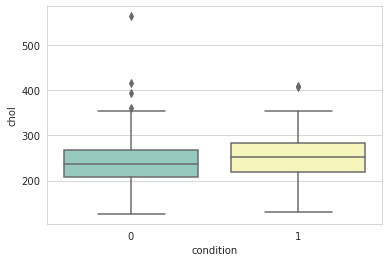

In [14]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="condition", y="chol",              
data=data, palette="Set3")

The violin plot below shows the relationship between cholesterol and heart disease (basically the same as the box and whiskers plot). There seems to be an outlier in the non-heart disease (0) column that may be due to technical or recording error. This being said, I don't think we can draw much of a conclusion from this graph.

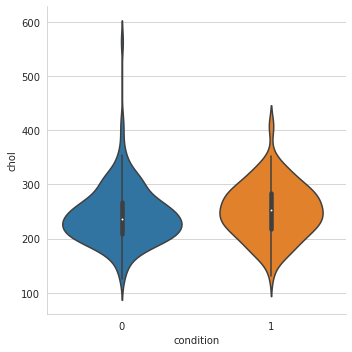

In [15]:
sns.catplot(
    data=data, x="condition", y="chol", kind="violin",
)

The next violin plot below shows the relationship between cholesterol and heart disease broken down by sex (0=female and 1=male). it seems that males have cholesterol levels that are more highly concentrated around the median. In general, it doesn't seem to show anything conclusive about cholesterol affecting heart disease.

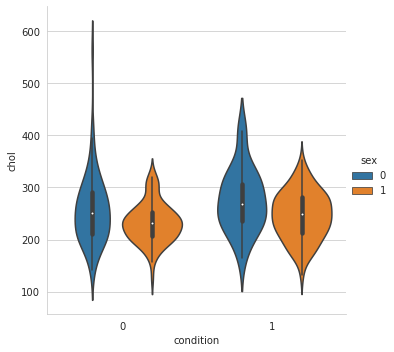

In [16]:
sns.catplot(
    data=data, x="condition", y="chol", hue="sex", kind="violin",
)

### Data analysis on: Exercise induced angina

The code below shows the role exercise induced angina plays on heart disease rates, we note that there seems to be a much higher rate of heart disease in the cases including exercise induced angina.

In [17]:
exang1 = data[data["exang"] == 1]
exang0 = data[data["exang"] == 0]
print("Heart disease rate when there's been exercise induced angina: ", np.mean(exang1['condition']))
print("Heart disease rate when there hasn't been exersize induced angina: ", np.mean(exang0['condition']))

Heart disease rate when there's been exercise induced angina:  0.7628865979381443
Heart disease rate when there hasn't been exersize induced angina:  0.315


The code below displays a bar chart showing male vs female patients and their rate of exercise induced angina. We can see that males account for more than double the cases.

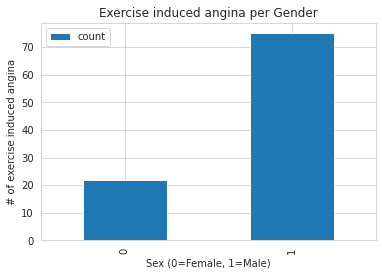

In [18]:
exM = data.groupby('sex').exang.sum().reset_index()
df_plot = pd.DataFrame({'sex': exM['sex'], 'count': exM['exang']})
df_plot.plot(kind='bar', x='sex', y='count')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('# of exercise induced angina')
plt.title('Exercise induced angina per Gender')
plt.show()

The bar chart below shows how how many heart disease cases there are broken down by exercise induced angina. We can see that there are more heart disease cases from those who had exercise induced angina vs. those who didn't

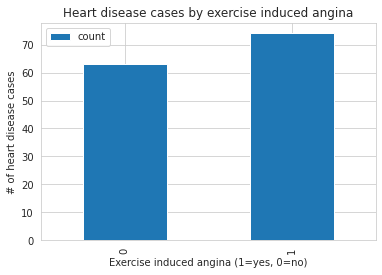

In [19]:
ex = data.groupby('exang').condition.sum().reset_index()
df_plot = pd.DataFrame({'exang': ex['exang'], 'count': ex['condition']})
df_plot.plot(kind='bar', x='exang', y='count')
plt.xlabel('Exercise induced angina (1=yes, 0=no)')
plt.ylabel('# of heart disease cases')
plt.title('Heart disease cases by exercise induced angina')
plt.show()

### Data Analysis on: Resting blood pressure 

In [20]:
# Calculate the average resting blood pressure in the dataset
avgRpb = np.mean(data['trestbps'])
print("Upon admission to the hospital, the average resting blood pressure is: ", avgRpb)

Upon admission to the hospital, the average resting blood pressure is:  131.69360269360268


The code below tells us what the heart disease rate is for those who were admitted with above vs below average resting blood pressure. Above average resting bp seems to have correlation with above avg resting bp.

In [21]:
dBp1 = data[data["trestbps"] > avgRpb]
gBpMean = np.mean(dBp1['condition'])
dBp2 = data[data["trestbps"] < avgRpb]
lBpMean = np.mean(dBp2['condition'])
print("Mean diease rate with above avg blood pressure ", gBpMean, "Compared to lower than avg blood pressure: ", lBpMean)

Mean diease rate with above avg blood pressure  0.5193798449612403 Compared to lower than avg blood pressure:  0.4166666666666667


The violin plot below shows the relationship between resting blood pressure and heart disease. We can see the the 1 column (positive for heart disease) seems to have a higher resting bp all around.

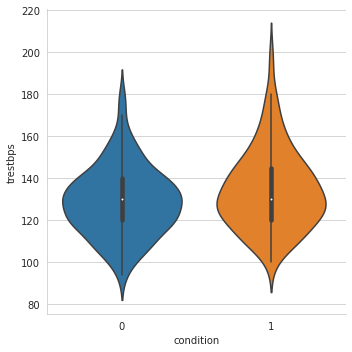

In [22]:
sns.catplot(
    data=data, x="condition", y="trestbps", kind="violin",
)

The violin plot below shows much of the same as the one above, except this is broken down further by sex. We can still see higher resting blood pressures in the 1 (heart disease) column, however, there doesn't seem to be any findings based on sex.

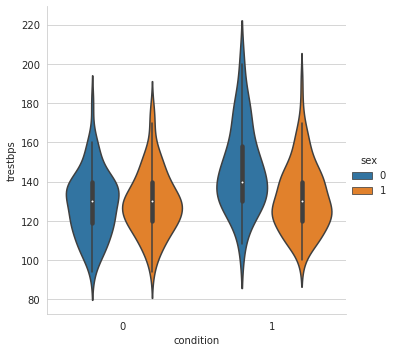

In [23]:
sns.catplot(
    data=data, x="condition", y="trestbps", hue="sex", kind="violin",
)

The plot below is a regression of resting blood pressure vs heart disease rates. It seems to show that the higher the resting blood pressure is upon hosptial admittance, the more likely you are to have heart disease.

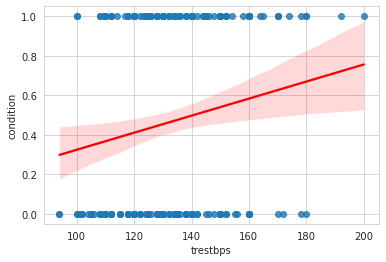

In [24]:
_ = sns.regplot(x = "trestbps", y = "condition",
                line_kws = {"color":"red"}, data = data)

## *Now we will do some ML*


#### Logistic regression:

In [25]:
# Creates logistic regression table, and compartmentalizes the categorical variables
data.cp = data.cp.astype('category')
data.restecg = data.restecg.astype('category')
data.ca = data.ca.astype('category')
m = smf.logit("condition ~ age	+sex+	cp+	trestbps+	chol+	fbs+	restecg+	thalach+	exang+	ca	", data = data).fit()
print(m.summary())
print(m.get_margeff().summary())

Optimization terminated successfully.
         Current function value: 0.362623
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                           15
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                  0.4746
Time:                        01:09:47   Log-Likelihood:                -107.70
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 2.716e-33
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.0087      2.559     -1.176      0.240      -8.023       2.006
cp[T.1]          0.3670

The following code chunks are used to create a logistic regression model, training data, testing data, as well as to test the accuracy of the model.

In [26]:
X = data[['age','sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'exang', 'ca']]
y = data.condition
X1 = pd.get_dummies(X, drop_first=True, columns=['cp','restecg','ca'])
m1 = LogisticRegression(penalty='none', solver='newton-cg').fit(X1,y)
print(m1.coef_) 
print(m1.intercept_)

[[ 0.01016448  1.90564671  0.02358306  0.00430757 -0.6149536   1.34354738
   0.14020277  0.10395135  1.95922182  1.85564075  0.43264103  1.89328859
   2.61903883  2.71866896]]
[-8.7245828]


In [27]:
train_y_prob = m1.predict_proba(X1)
train_y_prob1 = train_y_prob[:,1]
train_y_prob1[:10]

array([0.59258204, 0.25482206, 0.02811983, 0.50548172, 0.29127757,
       0.32107627, 0.12590304, 0.64296056, 0.02810122, 0.39513864])

In [28]:
train_y_problab = m1.predict(X1)
train_y_problab[:10]
threshold = 0.5
1.0*(train_y_prob1 > threshold) == train_y_problab

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [29]:
accuracy_score(train_y_problab, y)

0.8215488215488216

In [30]:
cm = confusion_matrix(y, train_y_problab)
cm

array([[137,  23],
       [ 30, 107]])

Based on the chunks of code from above and below, we can see that the logistic regression model is able to predict heart disease outcomes at a rate above 80%. While this may be a great rate in some cases, I think that if it were to be implemented in the medical realm it should be much higher, considering real lives could be on the line.

In [31]:
a = accuracy_score(y, train_y_problab)
p = precision_score(y, train_y_problab)
r = recall_score(y, train_y_problab)
print('Accuracy: ',a,'precision: ',p,'recall: ',r)

Accuracy:  0.8215488215488216 precision:  0.823076923076923 recall:  0.781021897810219


#### Support vector machine (SVM):

The code chunks below create and test an SVM model

In [32]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

Based on the code above, the SVM model is able to predict heart disease in this case at a rate above 80%. Once again, while this may be great in some cases, I'd like the accuracy rate to be much higher for medical use.

In [34]:
print('Accuracy for training set for svm = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for svm = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

Accuracy for training set for svm = 0.8693693693693694
Accuracy for test set for svm = 0.8133333333333334


#### Decision trees 

The code below dives into a decision tree model

In [35]:
X = data.drop('condition', axis=1)
y = data['condition']

In [36]:
# Splits data up 75% 25%, same everytime
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
mDt = DecisionTreeClassifier()
mDt.fit(X_train,y_train)
y_predDt = mDt.predict(X_test)

In [37]:
dtAccuracy = accuracy_score(y_test, y_predDt)
print("Accuracy score for decision tree model: ", dtAccuracy)

Accuracy score for decision tree model:  0.72


In [38]:
cmDt = confusion_matrix(y_test, y_predDt)
print(cmDt)

[[28 10]
 [11 26]]


The code above and the output it has generated shows us around 70% accuracy, which is definitely not ideal in this case.

#### Random Forests

The code below creates a random forest model

In [39]:
# Using the same training and testing data from above
mRf = RandomForestClassifier()
mRf.fit(X_train, y_train)
y_predRf = mRf.predict(X_test)
accuracyRf = accuracy_score(y_test, y_predRf)
print("Accuracy score for random forest model: ", accuracyRf)

Accuracy score for random forest model:  0.8


In [40]:
cmRf = confusion_matrix(y_test, y_predRf)
print(cmRf)

[[30  8]
 [ 7 30]]


The code above and the output it has generated shows us around 74% accuracy, which is definitely not ideal in this case.

#### Naive Bayes

The code below creates a naive bayes model

In [41]:
# Using the same training and testing data from above
mNb = GaussianNB()
mNb.fit(X_train, y_train)
y_predNb = mNb.predict(X_test)
accuracyNb = accuracy_score(y_test, y_predNb)
print("Accuracy for naive bayes model: ", accuracyNb)

Accuracy for naive bayes model:  0.7866666666666666


In [42]:
cmNb = confusion_matrix(y_test, y_predNb)
print(cmNb)

[[31  7]
 [ 9 28]]


The code above and the output it has generated shows us around 78% accuracy, which is better, but definitely not ideal in this case.